In [2]:
import os
import time
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import glob
import cv2
import csv
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision
from torchvision import transforms as T
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

In [3]:
DATASET = 'data'
TESTING = 'test_imgs'

files = glob.glob('data/**/*.txt', recursive = True) #find all *.txt files

target_txt = "train_dataset.txt"
test_txt = "test_set.txt"

In [3]:
#TRAINING DATASET

In [4]:
train_df = pd.read_csv(target_txt, sep=',', header=None, names=['img_path', 'x0', 'y0', 'x1', 'y1', 'label'])
train_df.head()

img_path     x0     y0     x1     y1  label
0  19-12-09_1652_624622812/000_03_04.png  463.0  204.0  560.0  241.0      2
1  19-12-09_1652_624622812/000_03_04.png   64.0  470.0  210.0  540.0      2
2  19-12-09_1652_624622812/000_03_04.png  267.0  464.0  332.0  535.0      1
3  19-12-09_1652_624622812/000_03_04.png  577.0  184.0  610.0  294.0      1
4  19-12-09_1652_624622812/000_03_04.png  346.0  268.0  421.0  366.0      1

In [4]:
train_df['img_path'].nunique()

6071

In [5]:
train_df['label'].value_counts()

1    26125
2     7456
Name: label, dtype: int64

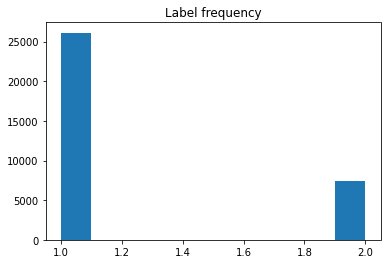

In [6]:
plt.title("Label frequency")
plt.hist(train_df['label'])
plt.show()

In [8]:
#TESTING DATASET

In [5]:
test_df = pd.read_csv(test_txt, sep=',', header=None, names=['img_path', 'x0', 'y0', 'x1', 'y1', 'label'])
test_df.head()

img_path   x0   y0   x1   y1  label
0  split4_033.png  165  303  493  402      1
1  split4_039.png  157  337  470  425      1
2  split4_057.png  247  404  626  472      1
3  split4_040.png  159  322  477  424      1
4  split4_041.png  164  343  477  421      1

In [8]:
test_df['img_path'].nunique()

158

In [9]:
test_df['label'].value_counts()

1    119
2     42
Name: label, dtype: int64

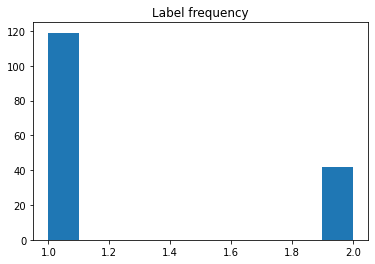

In [10]:
plt.title("Label frequency")
plt.hist(test_df['label'])
plt.show()

# TRAINING

In [6]:
#train shape
print(f"Train shape is {train_df.shape}")

#number of unique images
print(f"Unique images are {train_df['img_path'].nunique()}")

#number of images in dir
folder_images = []
for f in files:
  if "mask" not in f:
    folder_images.append(f)
print(f"Images in folder are {len(folder_images)}")

Train shape is (33581, 6)
Unique images are 6071
Images in folder are 12148


In [7]:
images_ids = train_df['img_path'].unique()

split_len = round(len(images_ids)*0.8) #80% -> train & 20% -> val

train_ids = images_ids[:split_len]
valid_ids = images_ids[split_len:]

train = train_df[train_df['img_path'].isin(train_ids)]
valid = train_df[train_df['img_path'].isin(valid_ids)]

print(f"Train shape is {train.shape} and Validation shape is {valid.shape}")

Train shape is (26861, 6) and Validation shape is (6720, 6)


In [9]:
train['label'].value_counts()

1    20675
2     6186
Name: label, dtype: int64

In [10]:
valid['label'].value_counts()

1    5450
2    1270
Name: label, dtype: int64

In [15]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
  figsize = (num_cols * scale, num_rows * scale)
  _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles and len(titles) > i:
      ax.set_title(titles[i])
  return axes

def show_bboxes(axes, bboxes, labels=None, colors=None):
  def _make_list(obj, default_values=None):
    if obj is None:
      obj = default_values
    elif not isinstance(obj, (list, tuple)):
      obj = [obj]
    return obj

  labels = _make_list(labels)
  colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
  for i, bbox in enumerate(bboxes):
    color = colors[i % len(colors)]
    rect = plt.Rectangle(
      xy=(bbox[0], bbox[1]),
      width=bbox[2] - bbox[0],
      height=bbox[3] - bbox[1],
      fill=False,
      edgecolor=color,
      linewidth=2)
    axes.add_patch(rect)
    if labels and len(labels) > i:
      text_color = 'k' if color == 'w' else 'w'
      axes.text(rect.xy[0], rect.xy[1], labels[i], va='center',
                ha='center', fontsize=9, color=text_color,
                bbox=dict(facecolor=color, lw=0))

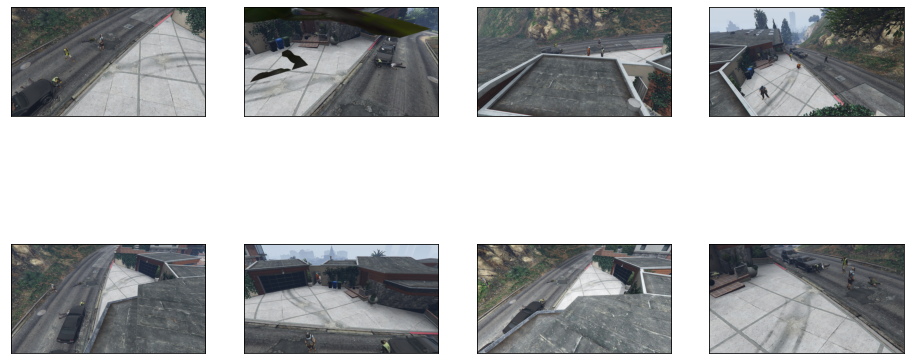

In [16]:
num_rows, num_cols = 2, 4
imgs = [plt.imread(f'{DATASET}/{n}') for n in train_df['img_path'].unique()[:num_rows*num_cols]]
show_images(imgs, num_rows, num_cols, scale=4)
plt.show()

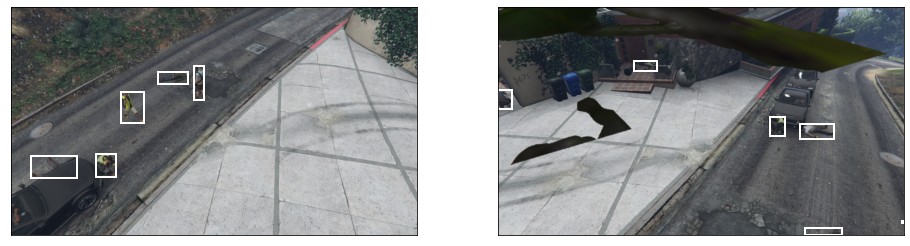

In [17]:
num_rows, num_cols = 1, 2
ids = train_df['img_path'].unique()[:num_rows*num_cols]
imgs = [plt.imread(f'{DATASET}/{n}') for n in ids]
axes = show_images(imgs, num_rows, num_cols, scale=8)
for ax, id in zip(axes, ids):
  datas = train_df[train_df['img_path'] == id]
  bboxes = [(d['x0'], d['y0'], d['x1'], d['y1']) for _, d in datas.iterrows()]
  show_bboxes(ax, bboxes, labels=None, colors=['w'])
plt.show()

In [20]:
#SHOW TESTING IMGS

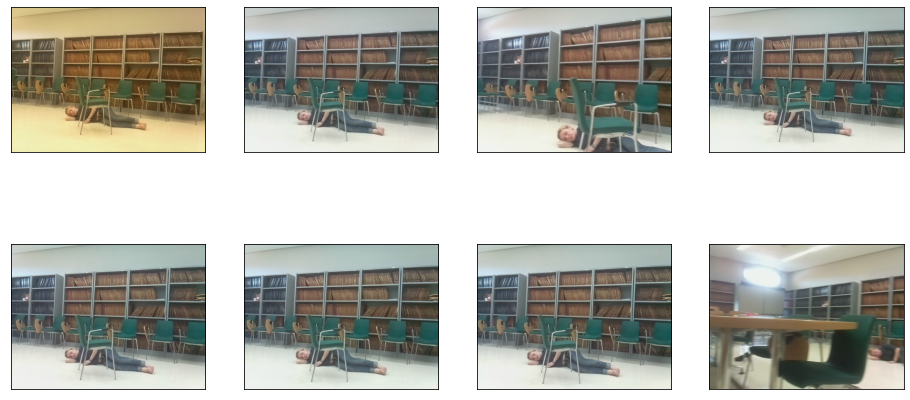

In [18]:
num_rows, num_cols = 2, 4
imgs = [plt.imread(f'{TESTING}/{n}') for n in test_df['img_path'].unique()[:num_rows*num_cols]]
show_images(imgs, num_rows, num_cols, scale=4)
plt.show()

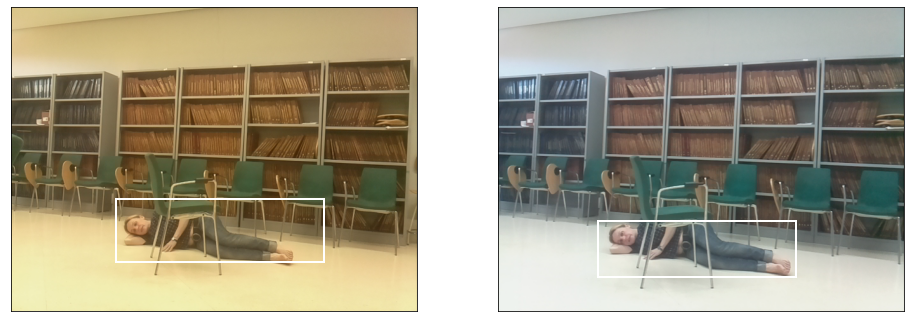

In [19]:
num_rows, num_cols = 1, 2
ids = test_df['img_path'].unique()[:num_rows*num_cols]
imgs = [plt.imread(f'{TESTING}/{n}') for n in ids]
axes = show_images(imgs, num_rows, num_cols, scale=8)
for ax, id in zip(axes, ids):
  datas = test_df[test_df['img_path'] == id]
  bboxes = [(d['x0'], d['y0'], d['x1'], d['y1']) for _, d in datas.iterrows()]
  show_bboxes(ax, bboxes, labels=None, colors=['w'])
plt.show()

In [20]:
# #get images with unique label
# df = train_df.groupby(['img_path','label']).size().reset_index(name='counts')
# img = df['img_path']
# not_dup = df[~img.isin(img[img.duplicated()])]
# print(not_dup)
# print(not_dup['label'].value_counts())
# label2_df = not_dup[not_dup['label'] == 2]
# labels2 = label2_df['img_path'].tolist() #list of all images path with only class label 2

                                   img_path  label  counts
0     19-12-05_1733_281439187/000_02_00.png      1       4
11    19-12-05_1733_281439187/000_04_00.png      1       1
12    19-12-05_1733_281439187/000_05_00.png      1       3
15    19-12-05_1733_281439187/000_05_02.png      1       3
16    19-12-05_1733_281439187/000_05_03.png      2       3
...                                     ...    ...     ...
8302  19-12-10_1334_699107828/000_01_02.png      1       4
8303  19-12-10_1334_699107828/000_01_03.png      1       5
8304  19-12-10_1334_699107828/000_01_04.png      1       4
8305  19-12-10_1334_699107828/000_02_00.png      1       3
8306  19-12-10_1334_699107828/000_02_01.png      1       5

[3829 rows x 3 columns]
1    3441
2     388
Name: label, dtype: int64


In [8]:
class FallenPeople(Dataset):

    def __init__(self, dataframe, img_dir, transforms):
        super().__init__()
        self.image_ids = dataframe['img_path'].unique()
        self.df = dataframe
        self.img_dir = img_dir
        self.transforms = transforms

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        records = self.df[self.df['img_path'] == image_id]
        
        image = cv2.imread(f'{self.img_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x0', 'y0', 'x1', 'y1']].values
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = records['label'].values
        labels = torch.as_tensor(labels, dtype = torch.int64)
        image_id = torch.tensor([idx])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.uint8)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target["image_id"] = image_id
        target['img_path'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowd'] = iscrowd

    #     if self.transforms is not None:
    #         sample = {'image': image, 'bboxes': target['boxes'], 'labels': labels}
    #         sample = self.transforms(**sample)
    #         image = sample['image']
    #         target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
#         if image_id in labels2:
#             self.transforms = Compose([
#                 T.Grayscale(num_output_channels=3)
#             ])
        if self.transforms is not None:
            image, target = self.transforms(image, target)
#             self.transforms = T.Compose([T.ToTensor()])


        return image, target

    def __len__(self) -> int:
        return len(self.image_ids)

In [9]:
import math
import numbers
import random
import warnings
from collections.abc import Sequence
from typing import Tuple, List, Optional
from PIL import Image, ImageOps, ImageEnhance

import torch
from torch import Tensor

try:
    import accimage
except ImportError:
    accimage = None

class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target
#*********************************************** 

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target
#***********************************************

class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            
        return image, target
    
#***********************************************

class ToPILImage(object):
    def __init__(self, mode=None):
        self.mode = mode

    def __call__(self, pic):
        return F.to_pil_image(pic, self.mode)
#***********************************************

class Grayscale(object):
    def __init__(self, prob, num_output_channels):
        self.prob = prob
        self.num_output_channels = num_output_channels

    def __call__(self, img, target):
        if random.random() < self.prob:
            return to_grayscale(ToPILImage()(img), target, num_output_channels=self.num_output_channels)
        return img,target

#***********************************************
def to_grayscale(img, target, num_output_channels=1):

    if num_output_channels == 1:
        img = img.convert('L')
    elif num_output_channels == 3:
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        img = ToTensor()(img,target)
    else:
        raise ValueError('num_output_channels should be either 1 or 3')

    return img

#***********************************************

def adjust_brightness(img, target, brightness_factor):
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(brightness_factor)
    img = ToTensor()(img,target)
    return img

def adjust_contrast(img, target, contrast_factor):
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(contrast_factor)
    img = ToTensor()(img,target)
    return img
#***********************************************
    
class ColorBright(object):
    def __init__(self, prob, brightness=0):
        self.prob = prob
        self.brightness = brightness

    def __call__(self, img, target):
        #transform = self.get_params(self.brightness, self.contrast,self.saturation, self.hue)
        if random.random() < self.prob:
            return adjust_brightness(ToPILImage()(img), target, self.brightness)
        return img, target
    
class ColorContrast(object):
    def __init__(self, prob, contrast=0):
        self.prob = prob
        self.contrast = contrast

    def __call__(self, img, target):
        #transform = self.get_params(self.brightness, self.contrast,self.saturation, self.hue)
        if random.random() < self.prob:
            return adjust_contrast(ToPILImage()(img), target, self.contrast)
        return img, target

In [10]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(RandomHorizontalFlip(0.5))
        transforms.append(Grayscale(0.5, num_output_channels=3))
        transforms.append(ColorBright(0.5, brightness=2))
        transforms.append(ColorContrast(0.5, contrast=2))
    return Compose(transforms)

In [11]:
train_dataset = FallenPeople(train, DATASET, get_transform(train=True))
valid_dataset = FallenPeople(valid, DATASET, get_transform(train=False))
test_dataset = FallenPeople(test_df, TESTING, get_transform(train=False))

In [35]:
import random

random_list = []

for i in range(15):
    random_list.append(random.randint(0,len(train_dataset)))

print(random_list)

[4788, 1323, 2721, 2756, 1848, 2902, 2357, 2650, 3977, 3220, 2777, 1634, 4774, 1970, 24]


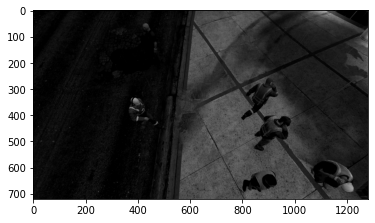

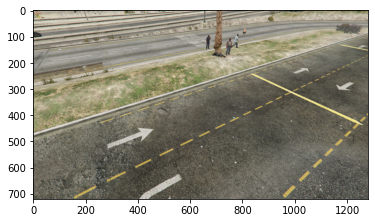

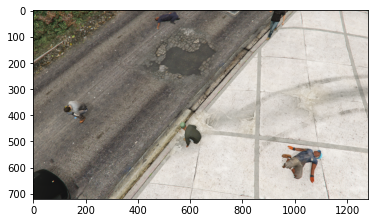

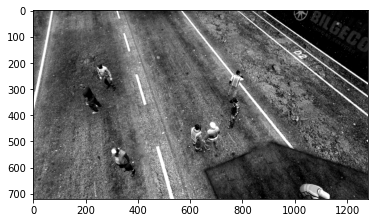

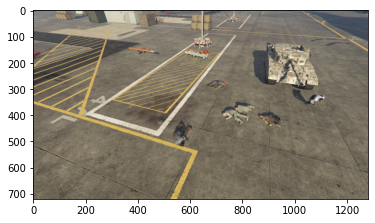

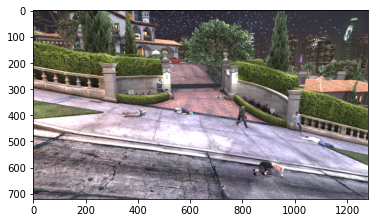

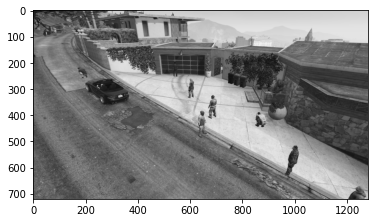

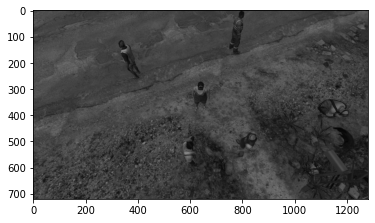

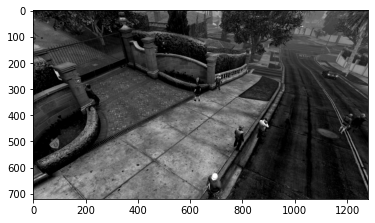

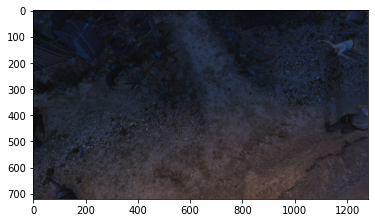

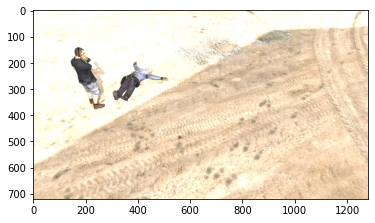

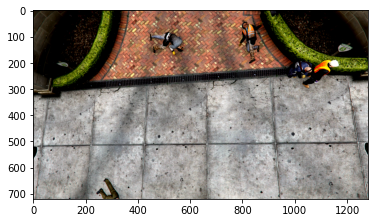

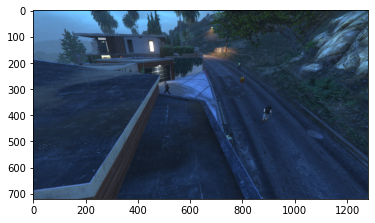

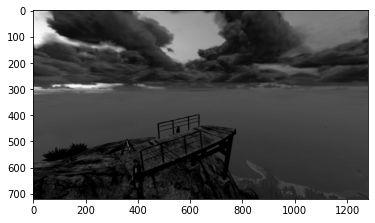

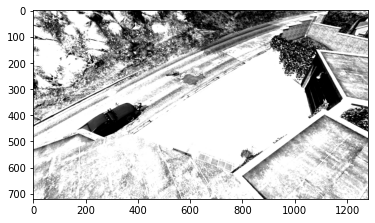

In [49]:
fig = plt.figure()

for i in random_list:
    img, target = train_dataset[i]
    #ax = plt.subplot(1, 4, i + 1)
    #plt.tight_layout()
    plt.imshow(img.permute(1,2,0))
    plt.show()
    if i == 15:
        break

In [12]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [13]:
print(model.roi_heads.box_predictor)

num_classes = 3 # fall or no fall or not(background)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained model's head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

print(model.roi_heads.box_predictor)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)
FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=3, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=12, bias=True)
)


In [14]:
def collate_fn(batch):
  return tuple(zip(*batch))

train_data_loader = DataLoader(
  train_dataset,
  batch_size=4,
  shuffle=False,
  collate_fn=collate_fn
)

valid_data_loader = DataLoader(
  valid_dataset,
  batch_size=4,
  shuffle=False,
  collate_fn=collate_fn
)

test_data_loader = DataLoader(
  test_dataset,
  batch_size=4,
  shuffle=False,
  collate_fn=collate_fn
)

In [21]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#***************
# move model to the right device
model.to(device)

# create an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# create a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

# train it for 10 epochs
num_epochs = 10

In [31]:
# def bb_intersection_over_union(boxA, boxB):
#     # determine the (x, y)-coordinates of the intersection rectangle
#     boxA = boxA.tolist()
#     boxB = boxB.tolist()
#     l = len(boxB)
#     iou_tot = []
#     for i in range(l): 
#         xA = max(boxA[i][0], boxB[i][0])
#         yA = max(boxA[i][1], boxB[i][1])
#         xB = min(boxA[i][2], boxB[i][2])
#         yB = min(boxA[i][3], boxB[i][3])
#         # compute the area of intersection rectangle
#         interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
#         # compute the area of both the prediction and ground-truth
#         # rectangles
#         boxAArea = (boxA[i][2] - boxA[i][0] + 1) * (boxA[i][3] - boxA[i][1] + 1)
#         boxBArea = (boxB[i][2] - boxB[i][0] + 1) * (boxB[i][3] - boxB[i][1] + 1)
#         # compute the intersection over union by taking the intersection
#         # area and dividing it by the sum of prediction + ground-truth
#         # areas - the interesection area
#         iou = interArea / float(boxAArea + boxBArea - interArea)
#         iou_tot.append(iou)
#     # return the intersection over union value
#     return iou

In [41]:
# def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
#     # You can comment out this line if you are passing tensors of equal shape
#     # But if you are passing output from UNet or something it will most probably
#     # be with the BATCH x 1 x H x W shape
#     outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
#     intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
#     union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
#     iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
#     thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
#     return thresholded

In [16]:
log_txt = "trainlogs/train_log_23_11_2021_unbalanced_dataset.txt"

In [17]:
%%bash
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-_4c6ws7x
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266204 sha256=872d1173a0e035e41613fe6010e82507a4f27ea79aa6ad4698fedba20f5ae387
  Stored in directory: /tmp/pip-ephem-wheel-cache-qo9xxjm4/wheels/25/c1/63/8bee2969883497d2785c9bdbe4e89cae5efc59521553d528bf
Successfully built pycocotools


  Running command git clone --filter=blob:none -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-_4c6ws7x


In [18]:
from engine import evaluate
import sys

original_stdout = sys.stdout

In [22]:
from tqdm.notebook import tqdm as tqdm
#training funzionante
itr = 1

total_train_loss = []
total_valid_loss = []

losses_value = 0.0

f_log = open(log_txt, "w")
for epoch in range(num_epochs):

  start_time = time.time()

  # train ------------------------------
  running_corrects = 0

  model.train()
  train_loss = []
  pbar = tqdm(train_data_loader, desc='let\'s train')
    
  for images, targets in pbar:    

    images = list(image.to(device) for image in images)

    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    losses_value = losses.item()
    train_loss.append(losses_value)   

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    if itr % 10:
        f_log.write(f"Epoch: {epoch+1}, Batch: {itr}, Loss: {losses_value}\n")
    pbar.set_description(f"Epoch: {epoch+1}, Batch: {itr}, Loss: {losses_value}")
    itr += 1
    
  epoch_train_loss = np.mean(train_loss)
  total_train_loss.append(epoch_train_loss)

  # update the learning rate
  if lr_scheduler is not None:
    lr_scheduler.step()
    
  #new valid
  sys.stdout = f_log
  evaluate(model, valid_data_loader, device=device)
  sys.stdout = original_stdout
  # valid -------------------------------------

#   with torch.no_grad():
#     valid_loss = []
    
#     for images, targets in valid_data_loader:
#       images = list(image.to(device) for image in images)
#       targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
#       loss_dict = model(images, targets)
#       losses = sum(loss for loss in loss_dict.values())
#       loss_value = losses.item()
#       valid_loss.append(loss_value)
    
#   epoch_valid_loss = np.mean(valid_loss)
#   total_valid_loss.append(epoch_valid_loss)  

#   # print ------------------------------
#   f_log.write(f"Epoch Completed: {epoch+1}/{num_epochs}, Time: {time.time()-start_time}, "
#         f"Train Loss: {epoch_train_loss}, Valid Loss: {epoch_valid_loss}\n")
#   f_log.write("\nTESTING PHASE: ")

#   print(f"Epoch Completed: {epoch+1}/{num_epochs}, Time: {time.time()-start_time}, "
#         f"Train Loss: {epoch_train_loss}, Valid Loss: {epoch_valid_loss}")
  print("\nTESTING PHASE... ")

  #testing --------------------------------------
  sys.stdout = f_log
  evaluate(model, test_data_loader, device=device)
  sys.stdout = original_stdout
#   with torch.no_grad():
#     valid_loss = []
#     model.eval()
    
#     for images, targets, image_ids in test_data_loader:
#       images = list(image.to(device) for image in images)
#       targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#       labels = targets[0]['boxes']
#       prediction = model(images)
#       outputs = prediction[0]['boxes']
# #       intersection = torch.logical_and(labels, outputs)
# #       union = torch.logical_or(labels, outputs)
# #       iou_score = torch.sum(intersection) / torch.sum(union)
# #       print("///////////////////////////////")
# #       print(iou_score)
# #       print("///////////////////////////////")
#       iou_score = bb_intersection_over_union(outputs, labels)
#       f_log.write(f"IOU: {iou_score}\n")
#       print("IoU: ", iou_score)
f_log.close()

let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


TESTING PHASE... 


In [20]:
!nvidia-smi

Tue Nov 23 14:45:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    On   | 00000000:03:00.0 Off |                  N/A |
| 80%   86C    P2   150W / 180W |   8016MiB /  8117MiB |     99%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    On   | 00000000:04:00.0 Off |                  N/A |
| 32%   44C    P8    10W / 180W |     12MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

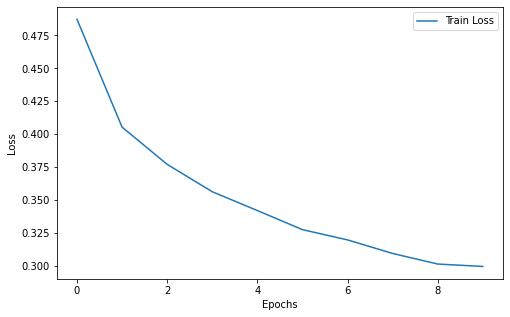

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(total_train_loss, label="Train Loss")
# plt.plot(total_valid_loss, label="Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [24]:
test_dataset[0]

(tensor([[[0.8745, 0.8745, 0.8549,  ..., 0.7020, 0.6863, 0.6471],
          [0.8745, 0.8706, 0.8627,  ..., 0.7059, 0.6902, 0.6431],
          [0.8549, 0.8627, 0.8627,  ..., 0.7137, 0.7137, 0.6510],
          ...,
          [0.9333, 0.9333, 0.9333,  ..., 0.9451, 0.9451, 0.9059],
          [0.9255, 0.9412, 0.9333,  ..., 0.9333, 0.9373, 0.9020],
          [0.9451, 0.9451, 0.9373,  ..., 0.9451, 0.9451, 0.9176]],
 
         [[0.7765, 0.7765, 0.7647,  ..., 0.6196, 0.5961, 0.5569],
          [0.7765, 0.7725, 0.7725,  ..., 0.6235, 0.6000, 0.5529],
          [0.7647, 0.7725, 0.7725,  ..., 0.6314, 0.6235, 0.5608],
          ...,
          [0.9098, 0.9098, 0.9098,  ..., 0.9176, 0.9098, 0.8706],
          [0.8902, 0.9059, 0.9098,  ..., 0.9059, 0.9020, 0.8667],
          [0.9098, 0.9098, 0.9137,  ..., 0.9176, 0.9098, 0.8824]],
 
         [[0.5451, 0.5451, 0.5333,  ..., 0.4784, 0.4549, 0.4157],
          [0.5451, 0.5412, 0.5412,  ..., 0.4824, 0.4588, 0.4118],
          [0.5412, 0.5490, 0.5412,  ...,

In [25]:
# pick one image from the test set
img, _ = test_dataset[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [26]:
prediction

[{'boxes': tensor([[301.4576, 355.5380, 444.0935, 409.0723],
          [236.0830, 337.4192, 446.4211, 412.9196],
          [177.8249, 361.9189, 215.0441, 377.2184],
          [177.8580, 327.9467, 222.4202, 361.3145],
          [ 79.5690, 240.5342, 104.7204, 291.1549],
          [506.7327, 338.8522, 517.7357, 379.9284],
          [159.2578, 284.3838, 175.0027, 315.3211],
          [239.7501, 275.7050, 312.0678, 306.3613],
          [219.0422, 324.4227, 244.9125, 396.7844],
          [346.0452, 365.6501, 446.8713, 405.0030],
          [236.6017, 364.7019, 260.3672, 387.2585],
          [510.3708, 276.6774, 534.7949, 348.5515],
          [210.4784, 325.0499, 261.9244, 393.9324],
          [178.0833, 360.3360, 255.2209, 379.0739]], device='cuda:1'),
  'labels': tensor([2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2], device='cuda:1'),
  'scores': tensor([0.5694, 0.2138, 0.1672, 0.1302, 0.1027, 0.0959, 0.0885, 0.0732, 0.0709,
          0.0630, 0.0583, 0.0560, 0.0508, 0.0505], device='cuda:1')}]

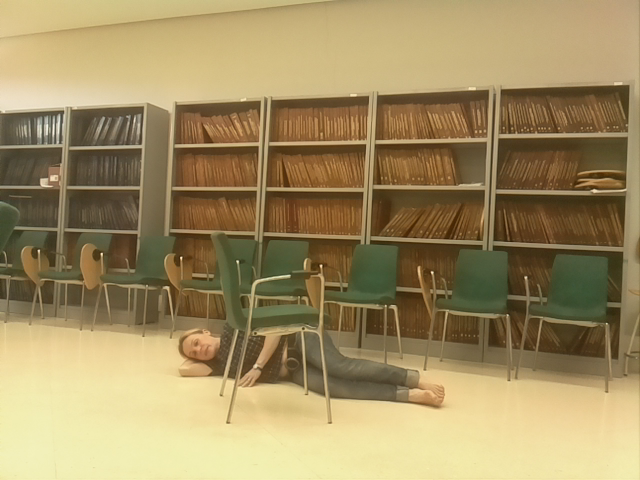

In [27]:
im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
im

In [28]:
from PIL import ImageDraw, ImageShow, ImageFont

[0.5693855285644531, 0.21377460658550262, 0.1671983301639557, 0.1302345097064972, 0.10274950414896011, 0.09585434198379517, 0.08851215988397598, 0.07318347692489624, 0.07090825587511063, 0.06301230192184448, 0.05831318348646164, 0.05595800653100014, 0.05076012760400772, 0.05048806220293045]


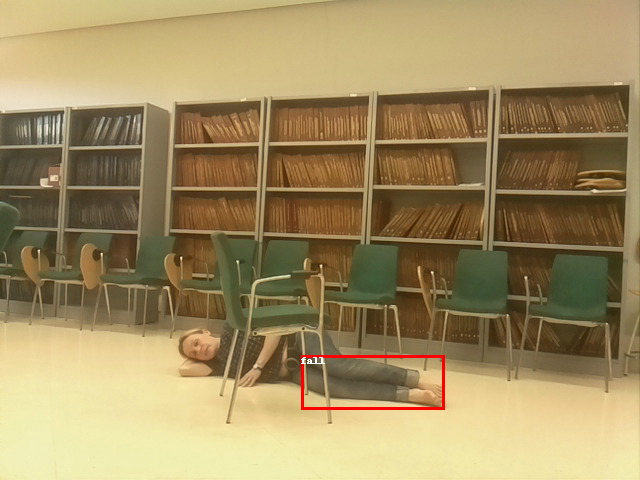

1

In [29]:
boxes = prediction[0]['boxes'].tolist()
labels = prediction[0]['labels'].tolist()
scores = prediction[0]['scores'].tolist()
l = len(scores)
# for b,l,s in boxes,labels,scores:
#     if s > 0.5:
#         if l == 1:
#             color = 'green'
#             text = 'no fall'
#         elif l == 2:
#             color = 'red'
#             text = 'fall'
#         x0,y0,x1,y1 = b
        
#         draw = ImageDraw.Draw(im)
#         draw.rectangle(((x0, y0),(x1,y1)), outline="green", width=3)

for i in range(l):
    if scores[i] > 0.5:
        if labels[i] == 1:
            color = 'green'
            text = 'no fall'
        elif labels[i] == 2:
            color = 'red'
            text = 'fall'
        x0,y0,x1,y1 = boxes[i]
        
        draw = ImageDraw.Draw(im)
        draw.rectangle(((x0, y0),(x1,y1)), outline=color, width=3)
        draw.text((x0, y0), text)
        
ImageShow.show(im)

In [30]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fallen_people_v1_2311_unbalanced_dataset.pth')

In [ ]:
#VEDIAMO UN SAMPLE DEL VALIDATION

In [31]:
valid_dataset[0]

(tensor([[[0.6941, 0.6941, 0.6941,  ..., 0.8157, 0.8196, 0.8196],
          [0.6941, 0.6941, 0.6941,  ..., 0.8157, 0.8196, 0.8196],
          [0.6941, 0.6941, 0.6941,  ..., 0.8157, 0.8196, 0.8196],
          ...,
          [0.4431, 0.4314, 0.4157,  ..., 0.4588, 0.4431, 0.4471],
          [0.4431, 0.4196, 0.3922,  ..., 0.4941, 0.4745, 0.4431],
          [0.4275, 0.4000, 0.3804,  ..., 0.4745, 0.4667, 0.4471]],
 
         [[0.5373, 0.5373, 0.5373,  ..., 0.7059, 0.7059, 0.7059],
          [0.5373, 0.5373, 0.5373,  ..., 0.7059, 0.7059, 0.7059],
          [0.5373, 0.5373, 0.5373,  ..., 0.7059, 0.7059, 0.7059],
          ...,
          [0.3961, 0.3804, 0.3765,  ..., 0.3922, 0.3922, 0.4078],
          [0.3804, 0.3647, 0.3529,  ..., 0.4706, 0.4353, 0.4039],
          [0.3725, 0.3490, 0.3373,  ..., 0.4353, 0.4510, 0.4510]],
 
         [[0.4588, 0.4588, 0.4588,  ..., 0.5961, 0.5961, 0.5961],
          [0.4588, 0.4588, 0.4588,  ..., 0.5961, 0.5961, 0.5961],
          [0.4588, 0.4588, 0.4588,  ...,

In [32]:
# pick one image from the test set
img, _ = valid_dataset[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction_valid = model([img.to(device)])

In [33]:
prediction_valid

[{'boxes': tensor([[7.8445e+02, 4.9245e+02, 1.0101e+03, 6.2346e+02],
          [1.0817e+01, 2.6334e+02, 5.0594e+01, 3.5250e+02],
          [4.2159e+02, 3.7515e+02, 5.2146e+02, 4.2441e+02],
          [3.0991e+02, 2.6688e+02, 3.2938e+02, 3.3937e+02],
          [5.9862e+02, 4.1294e+02, 7.1102e+02, 5.0876e+02],
          [9.5315e+02, 4.9882e+02, 1.0248e+03, 5.1876e+02],
          [1.7899e+00, 2.6458e+02, 1.6836e+01, 3.4234e+02],
          [1.2329e+03, 1.8537e+02, 1.2800e+03, 2.0144e+02],
          [9.4348e+00, 2.6488e+02, 2.6639e+01, 3.4120e+02],
          [1.1955e+03, 1.8547e+02, 1.2769e+03, 2.5991e+02],
          [1.2321e+03, 1.8497e+02, 1.2800e+03, 2.0167e+02],
          [3.0996e+02, 2.6964e+02, 3.2719e+02, 3.1050e+02],
          [7.8407e+02, 4.9107e+02, 9.4632e+02, 5.6643e+02],
          [1.0843e+00, 2.6961e+02, 9.4258e+00, 3.3935e+02],
          [6.0051e+02, 4.1497e+02, 7.1299e+02, 5.1008e+02]], device='cuda:1'),
  'labels': tensor([2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1], device

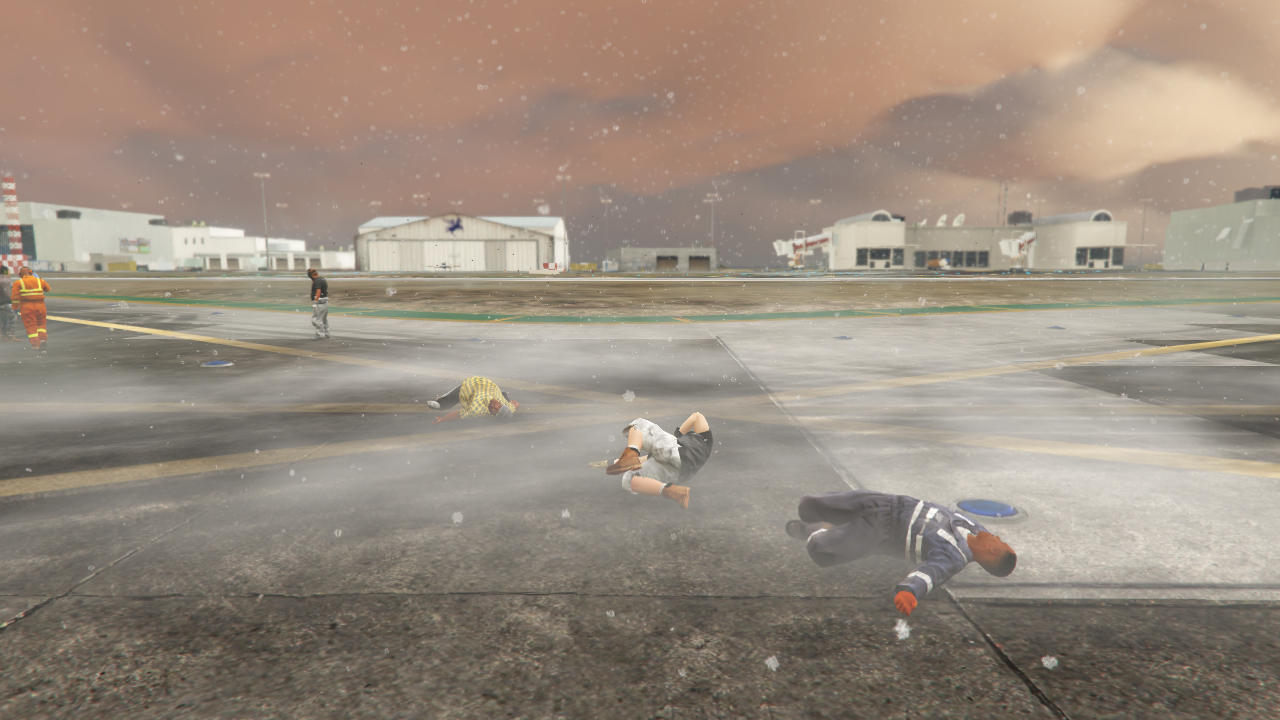

In [56]:
im2 = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
im2

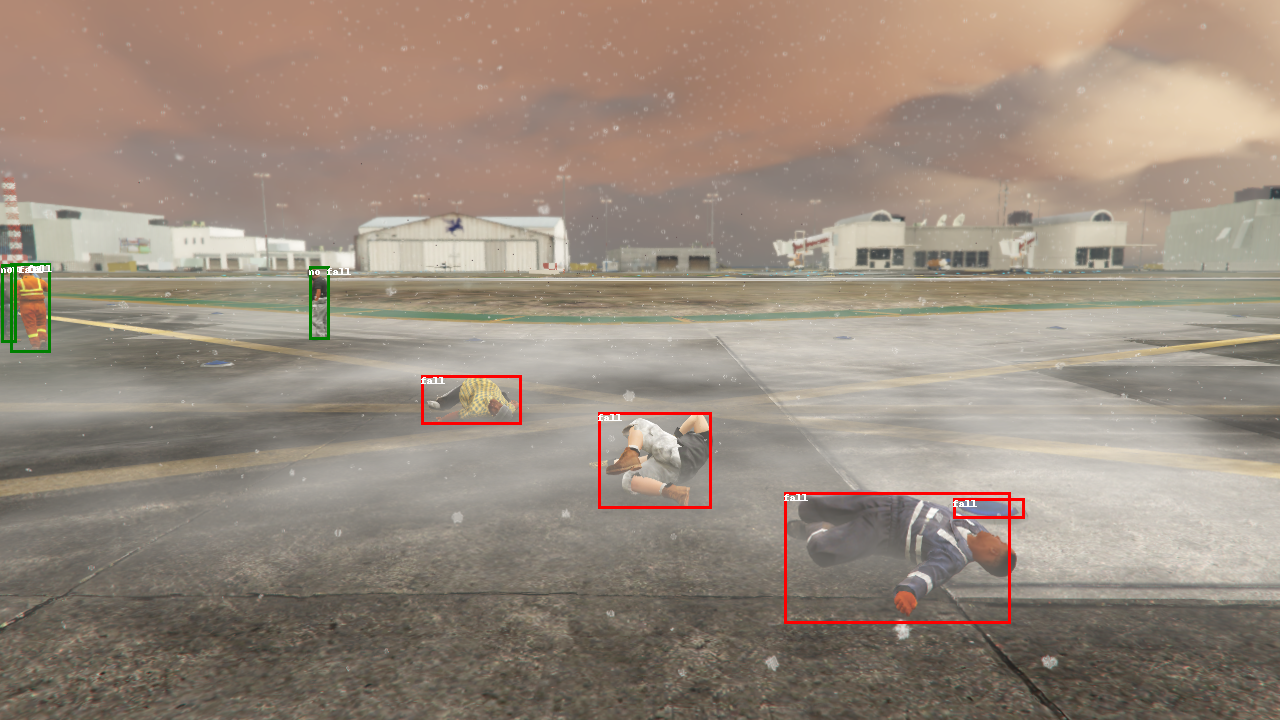

1

In [42]:
boxes = prediction_valid[0]['boxes'].tolist()
labels = prediction_valid[0]['labels'].tolist()
scores = prediction_valid[0]['scores'].tolist()
l = len(scores)
# for b,l,s in boxes,labels,scores:
#     if s > 0.5:
#         if l == 1:
#             color = 'green'
#             text = 'no fall'
#         elif l == 2:
#             color = 'red'
#             text = 'fall'
#         x0,y0,x1,y1 = b
        
#         draw = ImageDraw.Draw(im)
#         draw.rectangle(((x0, y0),(x1,y1)), outline="green", width=3)
for i in range(l):
    if scores[i] > 0.3:
        if labels[i] == 1:
            color = 'green'
            text = 'no fall'
        elif labels[i] == 2:
            color = 'red'
            text = 'fall'
        x0,y0,x1,y1 = boxes[i]
        
        draw = ImageDraw.Draw(im1)
        draw.rectangle(((x0, y0),(x1,y1)), outline=color, width=3)
        draw.text((x0, y0), text)
        
ImageShow.show(im1)

In [49]:
remaining = torchvision.ops.nms(prediction_valid[0]['boxes'], prediction_valid[0]['scores'], 0.5)

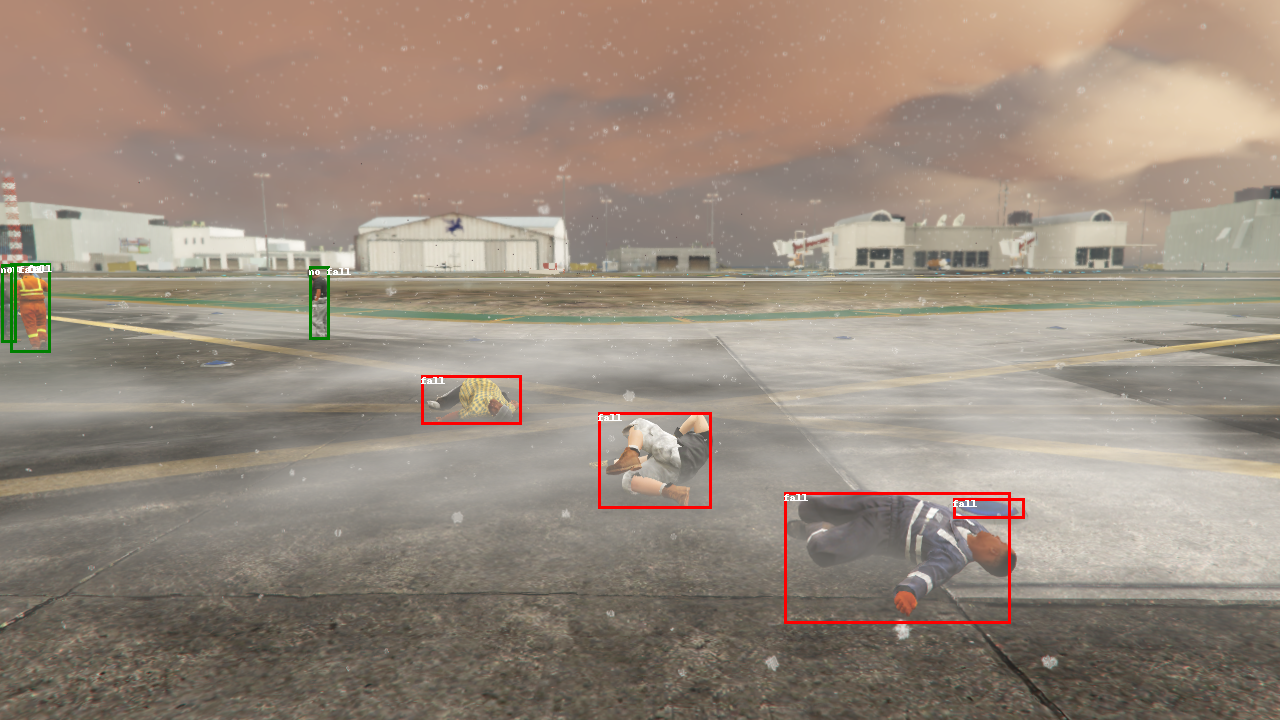

1

In [57]:
for i in rem_list:
    if scores[i] > 0.3:
        if labels[i] == 1:
            color = 'green'
            text = 'no fall'
        elif labels[i] == 2:
            color = 'red'
            text = 'fall'
        x0,y0,x1,y1 = boxes[i]
        
        draw = ImageDraw.Draw(im2)
        draw.rectangle(((x0, y0),(x1,y1)), outline=color, width=3)
        draw.text((x0, y0), text)
        
ImageShow.show(im2)